# THESIS NOTEBOOK - infer.py

### Libraries are imported here:

In [1]:
import numpy as np
from PIL import Image

import caffe
import vis

# own libraries
import colorgram
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import random
import shutil
import time
import datetime
import math
import sys

import score
import voc_layers

# sklearn libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# matplot libraries
import matplotlib.pyplot as plt

# graphviz library - visualization of trees library
import graphviz

### Constant and global variables:

In [2]:
# own code - Jasper
PRINT_SECONDS = 0.2
REVIEW_SECONDS = 5
REST_SECONDS = 10
ERROR_ABOVE = "Image {height, width} has above 1000 pixels"
PASS_BELOW = "Image {height, width} has below 1000 pixels"
OUTPUT_FOLDER = "output_score" # no slashes both first and last
OUTPUT_FOLDER_VALIDATION = "output_validate"
dm = "" # global dimensions string
JPG_FILETYPE = ".jpg"
PNG_FILETYPE = ".png"
loss = 0
over_acc_scores = []
mean_acc_scores = []
iu_scores = []
freq_scores = []
session_count = 0
plot = 0 # initialize plot for global use
n = 0 # initialize number of paintings for global use
LIMIT_X = 4 # limit columns for figure
labels = [] # labels for the confusion_matrix_board (x and y axis)

### Function section here:

#### trackSession

In [3]:
def trackSession():
    global session_count
    if session_count == 0:
        session_count += 1
        return True
    else:
        return False
    return False

#### setSession

In [4]:
def setSession(file, flag=True):
    now = datetime.datetime.now()
    if flag:
        file.write("\n-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))
    else:
        file.write("-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))

#### endSession

In [5]:
def endSession(flag=True):
    now = datetime.datetime.now()
    if flag:
        return "\n-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    else:
        return "-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    return ""

#### delayPrint

In [6]:
def delayPrint(string, seconds): # n seconds delay printing
    time.sleep(seconds)
    exportLogs(string)
    print(string)

#### getPaintings

In [7]:
def getPaintings(path):
    paintings = [f.split(JPG_FILETYPE)[0] for f in listdir(path) if isfile(join(path, f))] # splits only for .jpg images
    paintings.sort()
    return paintings

#### getLabels

In [8]:
def getLabels(path):
    paintings = [f.split(PNG_FILETYPE)[0] for f in listdir(path) if isfile(join(path, f))] # splits only for .png images
    paintings.sort()
    return paintings

#### exportLogs

In [9]:
def exportLogs(logs, f="demo/logs.log"):
    logs += "\n"
    if(isfile(f)):
        file = open(f, "a")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()
    else:
        print("Log file does not exist!")
        print("Creating {} file...".format(f))
        file = open(f, "a+")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()

#### createCurrentLog

In [10]:
def createCurrentLog(fp, output_folder=OUTPUT_FOLDER):
    filepath = fp.split("/")
    f = "demo/{}/{}.log".format(output_folder, filepath[len(filepath) - 1].split(JPG_FILETYPE)[0])
    if(isfile(f)):
        delayPrint("Resuming {} file".format(f), PRINT_SECONDS)
        file = open(f, "w")
        setSession(file, False)
        file.close()
    else:
        print("{} log file does not exist!".format(f))
        print("Creating {} file...".format(f))
        file = open(f, "w+")
        setSession(file, False)
        file.close()

#### readResume

In [11]:
def readResume(f="demo/resume.txt"):
    fp_resume = ""
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "r")
        delayPrint("Reading file...", PRINT_SECONDS)
        fp_resume = file.read()
        delayPrint("Last segmented image: {}".format(fp_resume.rstrip()), PRINT_SECONDS)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)
    return fp_resume

#### writeResume

In [12]:
def writeResume(current_painting_path, f="demo/resume.txt"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "w+")
        delayPrint("Saving last segmented image path...", PRINT_SECONDS)
        delayPrint("Writing file...", PRINT_SECONDS)
        file.write(current_painting_path)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)

#### writeErrorFile

In [13]:
def writeErrorFile(current_painting_path, error="", f="demo/error.log"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "a")
        delayPrint("Writing error file...", PRINT_SECONDS)
        file.write("{} - {}\n".format(current_painting_path, error))
        delayPrint("Closing error file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("{} log file does not exist!".format(f), PRINT_SECONDS)
        delayPrint("Creating {} file...".format(f), PRINT_SECONDS)
        delayPrint("Writing error file...", PRINT_SECONDS)
        file = open(f, "a+")
        file.write("{} - {}\n".format(current_painting_path, error))
        delayPrint("Closing error file...", PRINT_SECONDS)
        file.close()

#### reshapeInputLayer

In [14]:
def reshapeInputLayer(img, LINE_NUMBER=7, f="voc-fcn8s/test.prototxt"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    # LINE_NUMBER = 7
    width, height = img.size
    if(isfile(f)):
        with open(f, "r") as file:
            delayPrint("Reading file...", PRINT_SECONDS)
            data = file.readlines()
            delayPrint("Reshaping input layer...", PRINT_SECONDS)
            data[LINE_NUMBER] = "    shape { dim: 1 dim: 3 dim: %s dim: %s }\n"%(height, width)
            delayPrint(data[LINE_NUMBER], PRINT_SECONDS)
        with open(f, "w+") as file:
            delayPrint("Writing file...", PRINT_SECONDS)
            file.writelines(data)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)

#### reshapeLabelLayer

In [15]:
def reshapeLabelLayer(img, LINE_NUMBER=7, f="voc-fcn8s/test.prototxt"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    # LINE_NUMBER = 7
    width, height = img.size
    if(isfile(f)):
        with open(f, "r") as file:
            delayPrint("Reading file...", PRINT_SECONDS)
            data = file.readlines()
            delayPrint("Reshaping label layer...", PRINT_SECONDS)
            data[LINE_NUMBER] = "    shape { dim: 1 dim: %s dim: %s }\n"%(height, width)
            delayPrint(data[LINE_NUMBER], PRINT_SECONDS)
        with open(f, "w+") as file:
            delayPrint("Writing file...", PRINT_SECONDS)
            file.writelines(data)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)

#### checkImageSize1000000

In [16]:
def checkImageSize1000000(img):
    delayPrint("Checking if image {width, height} has 1,000,000 and above pixels...", PRINT_SECONDS)
    width, height = img.size
    dimensions = " - ({} x {})".format(height, width)
    global dm
    dm = dimensions
    ONE_MIL = 1000000
    delayPrint("Images (H x W) has dimensions {} x {}".format(height, width), PRINT_SECONDS)
    if((width * height) >= ONE_MIL):
        delayPrint(ERROR_ABOVE+dimensions, PRINT_SECONDS)
        return True
    else:
        delayPrint(PASS_BELOW+dimensions, PRINT_SECONDS)
        return False
    return False

#### validationResultsLog

In [17]:
def validationResultsLog(current_painting_path, results, f="demo/results.log"):
    global loss
    global over_acc_scores
    global mean_acc_scores
    global iu_scores
    global freq_scores
    loss += results['loss']
    over_acc_scores.append(results['over_acc'])
    mean_acc_scores.append(results['mean_acc'])
    iu_scores.append(results['iu'])
    freq_scores.append(results['freq'])
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "a")
        delayPrint("Writing results file...", PRINT_SECONDS)
        file.write("{}\n".format(current_painting_path))
        file.write("\t\tLoss: {}\n".format(results['loss']))
        file.write("\t\tOverall accuracy: {}\n".format(results['over_acc']))
        file.write("\t\tMean accuracy: {}\n".format(results['mean_acc']))
        file.write("\t\tMean IU: {}\n".format(results['iu']))
        file.write("\t\tFwavacc accuracy: {}\n".format(results['freq']))
        file.write("\n")
        delayPrint("Closing results file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("{} log file does not exist!".format(f), PRINT_SECONDS)
        delayPrint("Creating {} file...".format(f), PRINT_SECONDS)
        delayPrint("Writing results file...", PRINT_SECONDS)
        file = open(f, "a+")
        file.write("{}\n".format(current_painting_path))
        file.write("\t\tLoss: {}\n".format(results['loss']))
        file.write("\t\tOverall accuracy: {}\n".format(results['over_acc']))
        file.write("\t\tMean accuracy: {}\n".format(results['mean_acc']))
        file.write("\t\tMean IU: {}\n".format(results['iu']))
        file.write("\t\tFwavacc accuracy: {}\n".format(results['freq']))
        file.write("\n")
        delayPrint("Closing results file...", PRINT_SECONDS)
        file.close()

#### computeMeanScore

In [18]:
def computeMeanScore(f="demo/results.log"):
    global loss
    global over_acc_scores
    global mean_acc_scores
    global iu_scores
    global freq_scores
    over_acc_scores = np.mean(over_acc_scores)
    mean_acc_scores = np.mean(mean_acc_scores)
    iu_scores = np.mean(iu_scores)
    freq_scores = np.mean(freq_scores)
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "a")
        delayPrint("Writing mean results file...", PRINT_SECONDS)
        file.write("Mean Results:\n")
        file.write("\t\tLoss: {}\n".format(loss))
        file.write("\t\tOverall accuracy (mean): {}\n".format(over_acc_scores))
        file.write("\t\tMean accuracy (mean): {}\n".format(mean_acc_scores))
        file.write("\t\tMean IU (mean): {}\n".format(iu_scores))
        file.write("\t\tFwavacc accuracy (mean): {}\n".format(freq_scores))
        delayPrint("Closing mean results file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("{} log file does not exist!".format(f), PRINT_SECONDS)
        delayPrint("Creating {} file...".format(f), PRINT_SECONDS)
        delayPrint("Writing mean results file...", PRINT_SECONDS)
        file = open(f, "a+")
        file.write("Mean Results:\n")
        file.write("\t\tLoss: {}\n".format(loss))
        file.write("\t\tOverall accuracy (mean): {}\n".format(over_acc_scores))
        file.write("\t\tMean accuracy (mean): {}\n".format(mean_acc_scores))
        file.write("\t\tMean IU (mean): {}\n".format(iu_scores))
        file.write("\t\tFwavacc accuracy (mean): {}\n".format(freq_scores))
        delayPrint("Closing mean results file...", PRINT_SECONDS)
        file.close()
    return {'loss_a' : loss, 'over_acc_m' : over_acc_scores, 'mean_acc_m' : mean_acc_scores, 'iu_m' : iu_scores, 'freq_m' : freq_scores}

#### loop

In [19]:
def loop(paintings_path, labels_path, paintings, current_painting):
    global n
    global plot
    n = int(input("Enter number of images to segment: "))
    index = paintings.index(current_painting.split(JPG_FILETYPE)[0])
    end = len(paintings) - 1
    last = index+n
    if(index != 0):
        if(index == end):
            last = end
        else:
            index += 1
            last += 1
    delayPrint("Choose one of the following:\n", PRINT_SECONDS)
    delayPrint("[1] Segmentation\t\t[2] Validation", PRINT_SECONDS)
    option = int(input("Your answer [1/2]: "))
    while option != 1 and option != 2:
        option = int(input("Your answer [1/2]: "))

    # creating Figure
    plot = createFigure(n)
    
    for x in range(index, last):
        current_painting_path = paintings_path + "/" + paintings[x] + JPG_FILETYPE
        current_label_path = labels_path + "/" + paintings[x] + PNG_FILETYPE
        delayPrint(current_painting_path, PRINT_SECONDS)
        createCurrentLog(paintings[x], OUTPUT_FOLDER) if option is 1 else createCurrentLog(paintings[x], OUTPUT_FOLDER_VALIDATION)
        start_time = datetime.datetime.now()
        delayPrint("---------- Start Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)
        delayPrint("Index of painting: {}".format(x), PRINT_SECONDS)
        delayPrint("Last expected painting index: {}".format(last - 1), PRINT_SECONDS)
        delayPrint("", REVIEW_SECONDS)
#         try:
        if option == 1:
            segmentation(current_painting_path, paintings[x])
        else:
            results = validation(current_painting_path, current_label_path, paintings[x])
            plot = collectConfusionMatrix(plot, x-index+1, results[1])
            validationResultsLog(current_painting_path, results[0])
#         except:
#             error = sys.exc_info()[0]
#             print("Error {} found! Writing error log.".format(error))
#             writeErrorFile(current_painting_path, error)
        end_time = datetime.datetime.now()
        delayPrint("---------- End Time - {:s} ----------".format(str(end_time)), PRINT_SECONDS)
        elapsed_time = end_time - start_time
        delayPrint("Elapsed time is: {:s}".format(str(elapsed_time)), REVIEW_SECONDS)
        delayPrint("Index of painting: {}".format(x), PRINT_SECONDS)
        delayPrint("Last expected painting index: {}".format(last - 1), PRINT_SECONDS)
        delayPrint("", REVIEW_SECONDS)
        if int(n) > 1 and x != last - 1: # rest (60 seconds) if images are greater to 1 and no rest if last image
            time.sleep(REST_SECONDS)
        # if x == last - 1:
        writeResume(current_painting_path)
    if option is 2:
        mean_scores = computeMeanScore()
        delayPrint("Loss: {}".format(mean_scores["loss_a"]), PRINT_SECONDS)
        delayPrint("Overall Accuracy (mean): {}".format(mean_scores["over_acc_m"]), PRINT_SECONDS)
        delayPrint("Mean Accuracy (mean): {}".format(mean_scores["mean_acc_m"]), PRINT_SECONDS)
        delayPrint("Mean IU (mean): {}".format(mean_scores["iu_m"]), PRINT_SECONDS)
        delayPrint("Fwavacc Accuracy (mean): {}".format(mean_scores["freq_m"]), PRINT_SECONDS)
        
        # show the figure of the collected confusion matrix
        showFigure()
    delayPrint(endSession(), PRINT_SECONDS)

#### segmentation

In [20]:
def segmentation(path, current_painting):
    # the demo image is "2007_000129" from PASCAL VOC

    # load image, switch to BGR, subtract mean, and make dims C x H x W for Caffe
    # im = Image.open('demo/image.jpg')
    # path = "demo/Trials/twice.jpg"
    im = Image.open(path)
    if checkImageSize1000000(im):
        writeErrorFile(path, ERROR_ABOVE+dm)
    else:
        # reshape input layer from dimensions of image H x W
        reshapeInputLayer(im, 7)
        delayPrint("Starting to segment the image -- {} -- in {} seconds".format(current_painting, REVIEW_SECONDS), PRINT_SECONDS)
        # delay for 5 seconds for reviewing of image name
        time.sleep(REVIEW_SECONDS)
        in_ = np.array(im, dtype=np.float32)
        # print(in_)
        in_ = in_[:,:,::-1]
        # time.sleep(120)
        in_ -= np.array((104.00698793,116.66876762,122.67891434))
        in_ = in_.transpose((2,0,1))

        # Own code:
        # Set mode to CPU since GPU can't handle much memory
        caffe.set_mode_cpu()
        # load net
        net = caffe.Net('voc-fcn8s/test.prototxt', 'voc-fcn8s/fcn8s-heavy-pascal.caffemodel', caffe.TEST)
        # shape for input (data blob is N x C x H x W), set data
        net.blobs['data'].reshape(1, *in_.shape)
        net.blobs['data'].data[...] = in_

        # print("Stopping...")
        # return
        

        # run net and take argmax for prediction
        net.forward()
        out = net.blobs['score'].data[0].argmax(axis=0)

        # visualize segmentation in PASCAL VOC colors
        voc_palette = vis.make_palette(21)
        out_im = Image.fromarray(vis.color_seg(out, voc_palette))
        # image_pixels = ""
        # ycount_gt = 0
        # ycount_out = 0
        # for y in gt_:
        #     for x in y:
        #         # image_pixels += str(x)
        #         if x == 4:
        #             ycount_gt += 1
        #     # image_pixels += "\n"
        # for y in out_:
        #     for x in y:
        #         # image_pixels += str(x)
        #         if x == 4:
        #             ycount_out += 1
            # image_pixels += "\n"
        # print("Accuracy of 4: {:.5f}".format(ycount_out/ycount_gt))
        # print(ycount)
        # # print(image_pixels)
        # with open("test.txt", "a+") as file:
        #     file.writelines(image_pixels)
        # out_im.save('demo/output.png')
        out_im.save('demo/%s/output_%s.png'%(OUTPUT_FOLDER, current_painting.split(JPG_FILETYPE)[0]))
        logfile = "demo/"+OUTPUT_FOLDER+"/"+current_painting+".log"
        masked_im = Image.fromarray(vis.vis_seg(im, out, voc_palette, 0.5, logfile))

        # print extracted colors of original image
        vis.extractColors(path, logfile)

        # masked_im.save('demo/visualization.jpg')
        masked_im.save('demo/%s/output_%s.jpg'%(OUTPUT_FOLDER, current_painting))

#### valdation

In [21]:
def validation(painting_path, label_path, current_painting):
    im = Image.open(painting_path)
    gt = Image.open(label_path)
    gt = gt.resize(gt.size, Image.ANTIALIAS)
    if checkImageSize1000000(im):
        writeErrorFile(painting_path, ERROR_ABOVE+dm)
    else:
        # reshape input layer from dimensions of image H x W
        reshapeInputLayer(im, 7)
        reshapeLabelLayer(gt, 15)
        delayPrint("Starting to validate the image -- {} -- in {} seconds".format(current_painting, REVIEW_SECONDS), PRINT_SECONDS)
        # delay for 5 seconds for reviewing of image name
        time.sleep(REVIEW_SECONDS)
        in_ = np.array(im, dtype=np.float32)

        # try ground truth
        gt_ = np.array(gt, dtype=np.float32)
        # gt_ = gt_[np.newaxis, ...]
        # print(in_)
        in_ = in_[:,:,::-1]
        # print(in_)
        # print(gt_)
        # gt_ = gt_[:,:,::-1]
        # time.sleep(120)
        in_ -= np.array((104.00698793,116.66876762,122.67891434))
        in_ = in_.transpose((2,0,1))

        # gt_ -= np.array((104.00698793,116.66876762,122.67891434))
        # gt_ = gt_.transpose((2,0,1))

        # Own code:
        # Set mode to CPU since GPU can't handle much memory
        caffe.set_mode_cpu()
        # load net
        net = caffe.Net('voc-fcn8s/test.prototxt', 'voc-fcn8s/fcn8s-heavy-pascal.caffemodel', caffe.TEST)
        # shape for input (data blob is N x C x H x W), set data
        # net.blobs['label'].data = gt_ 
        
        # print(net.blobs)
        
        net.blobs['data'].reshape(1, *in_.shape)
        net.blobs['data'].data[...] = in_
        # net.blobs['label'].reshape(1, *gt_.shape)
        net.blobs['label'].data[...] = gt_

        # print("Stopping...")
        # return
        

        # run net and take argmax for prediction
        net.forward()
        
        out = net.blobs['score'].data[0].argmax(axis=0)
        voc_palette = vis.make_palette(21)
        out_im = Image.fromarray(vis.color_seg(out, voc_palette))
        out_im.save('demo/%s/output_%s.png'%(OUTPUT_FOLDER_VALIDATION, current_painting.split(JPG_FILETYPE)[0]))
        logfile = "demo/"+OUTPUT_FOLDER_VALIDATION+"/"+current_painting+".log"
        masked_im = Image.fromarray(vis.vis_seg(im, out, voc_palette, 0.5, logfile))

        # print extracted colors of original image
        vis.extractColors(painting_path, logfile)

        # masked_im.save('demo/visualization.jpg')
        masked_im.save('demo/%s/output_%s.jpg'%(OUTPUT_FOLDER_VALIDATION, current_painting))
        
        # store data for label and segmented 
        out_ = np.array(out, dtype=np.float32)
        lbl_ = np.array(gt, dtype=np.float32)
        
        delayPrint("Ground truth image array: {}".format(np.unique(gt_.flatten())), PRINT_SECONDS)
        delayPrint("Segmentation result image array: {}".format(np.unique(out_.flatten())), PRINT_SECONDS)
        
        # check accuracy
        # val = np.loadtxt('demo/valid.txt', dtype=str)
        val = np.array([1], dtype=np.uint8)

        # reshaping blobs to 1-dimension
        # net.blobs['data'].reshape(1,)
        # net.blobs['label'].reshape(1,)
        conf_mx = createConfusionMatrix(lbl_.flatten(), out_.flatten())
        return (score.do_seg_tests(net, 1, False, val, layer='score', gt='label'), conf_mx)

#### createConfusionMatrix

In [22]:
def createConfusionMatrix(label, segmented):
    global labels
    class_names = ["background", "aeroplane", "bicycle", "bird",
               "boat", "bottle", "bus", "car",
               "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person",
               "pottedplant", "sheep", "sofa", "train",
               "tvmonitor"]
    delayPrint("Creating confusion matrix...", PRINT_SECONDS)
    lbl_seg_ci_lst = list(map(int, list(set(list(np.unique(label)) + list(np.unique(segmented))))))
    labels = lbl_seg_ci_lst
#     print(labels)
#     print("List of lbl_seg: {}".format(lbl_seg_ci_lst))
#     print("1st element of lbl_seg: {}".format(class_names[lbl_seg_ci_lst[0]]))
#     print("Type of ignore element of lbl: {}".format(lbl_seg_ci_lst[5] == 255))
#     label = list(map(int, label))
#     segmented = list(map(int, segmented))
#     label = list(map((lambda x: "ignore" if x == 255 else class_names[x]), label))
#     segmented = list(map((lambda x: "ignore" if x == 255 else class_names[x]), segmented))
#     conf_mx = confusion_matrix(label, segmented, labels=list(map((lambda x: "ignore" if x == 255 else class_names[x]), lbl_seg_ci_lst)))
#     plt.matshow(conf_mx, cmap=plt.cm.gray)
    conf_mx = confusion_matrix(label, segmented)
    return conf_mx

#### getYLimitValue

In [23]:
def getYLimitValue(n):
    global LIMIT_X
    if n % LIMIT_X == 0:
        y = int(n / LIMIT_X)
    else:
        y = int((n / LIMIT_X)) + 1
    return y

#### createFigure

In [24]:
def createFigure(n):
    global LIMIT_X
    y = getYLimitValue(n)
    x = LIMIT_X
    delayPrint("Creating figure...", PRINT_SECONDS)
    fig, axes = plt.subplots(y, x)
    fig.set_size_inches(30,20)
    return fig, axes

#### showFigure

In [25]:
def showFigure():
    delayPrint("Showing figure...", PRINT_SECONDS)
#     plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

#### collectConfusionMatrix

In [26]:
def collectConfusionMatrix(plot, current_index, conf_mx):
    global LIMIT_X
    global labels
    global n
    class_names = ["background", "aeroplane", "bicycle", "bird",
               "boat", "bottle", "bus", "car",
               "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person",
               "pottedplant", "sheep", "sofa", "train",
               "tvmonitor"]
    
    delayPrint("Collecting confusion matrix...", PRINT_SECONDS)
    index = 0
    fig, axes = plot
    for y in range(getYLimitValue(current_index)):
        for x in range(LIMIT_X):
#             print("{} check condition: {}".format(index, (index is n - 1)))
            if index == current_index - 1:
                delayPrint("Storing confusion matrix...", PRINT_SECONDS)
#                 print("{}, {}".format(y, x))
                if current_index > LIMIT_X:
                    axes[y, x].matshow(conf_mx, cmap=plt.cm.gray)
                    axes[y, x].set_xticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                    axes[y, x].set_yticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                else:
                    axes[x].matshow(conf_mx, cmap=plt.cm.gray)
                    axes[x].set_xticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                    axes[x].set_yticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
            elif index > current_index - 1:
                if current_index > LIMIT_X:
                    if current_index >= n:
                        fig.delaxes(axes[y, x])
                else:
                    if current_index >= n:
                        fig.delaxes(axes[x])
            index += 1
    return fig, axes

### Main process here:

Checking demo/resume.txt file...
Reading file...
Last segmented image: demo/test/presentation_voc/JPEGImages/albert-bierstadt_bison-with-coyotes-in-the-background.jpg
Closing file...
Enter number of images to segment: 4
Choose one of the following:

[1] Segmentation		[2] Validation
Your answer [1/2]: 2
Creating figure...
demo/test/presentation_voc/JPEGImages/albert-bierstadt_bison-with-coyotes-in-the-background.jpg
Resuming demo/output_validate/albert-bierstadt_bison-with-coyotes-in-the-background.log file
---------- Start Time - 2018-09-01 10:17:27.918349 ----------
Index of painting: 0
Last expected painting index: 3

Checking if image {width, height} has 1,000,000 and above pixels...
Images (H x W) has dimensions 352 x 502
Image {height, width} has below 1000 pixels - (352 x 502)
Checking voc-fcn8s/test.prototxt file...
Reading file...
Reshaping input layer...
    shape { dim: 1 dim: 3 dim: 352 dim: 502 }

Writing file...
Closing file...
Checking voc-fcn8s/test.prototxt file...
Read

/home/butchersix/fcn.berkeleyvision.org/score.py:115: RuntimeWarning: invalid value encountered in true_divide
  mean_acc = np.diag(hist) / hist.sum(1)
/home/butchersix/fcn.berkeleyvision.org/score.py:119: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


>>>2018-09-01 10:17:59.114047 Iteration: 1 Mean Accuracy: 0.49793025852876227
>>>2018-09-01 10:17:59.315967 Iteration: 1 Mean IU: 0.19220665570077705
>>>2018-09-01 10:17:59.517667 Iteration: 1 Fwavacc: 0.9226096098565758
Storing confusion matrix...
Checking demo/results.log file...
Writing results file...
Closing results file...
---------- End Time - 2018-09-01 10:18:00.887871 ----------
Elapsed time is: 0:00:32.969522
Index of painting: 0
Last expected painting index: 3

Checking demo/resume.txt file...
Saving last segmented image path...
Writing file...
Closing file...
demo/test/presentation_voc/JPEGImages/alexey-venetsianov_checkered-shawl.jpg
Resuming demo/output_validate/alexey-venetsianov_checkered-shawl.log file
---------- Start Time - 2018-09-01 10:18:22.724447 ----------
Index of painting: 1
Last expected painting index: 3

Checking if image {width, height} has 1,000,000 and above pixels...
Images (H x W) has dimensions 256 x 185
Image {height, width} has below 1000 pixels - (

Writing file...
Closing file...
Checking voc-fcn8s/test.prototxt file...
Reading file...
Reshaping label layer...
    shape { dim: 1 dim: 344 dim: 269 }

Writing file...
Closing file...
Starting to validate the image -- alexey-venetsianov_peasant-woman-with-milk -- in 5 seconds
Number of pixels: 92536
Extract Unique Pixel Classes:

1. [0, 0, 0]
2. [0, 192, 0]
3. [192, 128, 128]
---------- Class Names - RGB Value ----------
Class ID: 0
Class Color: (0, 0, 0)
Class Name: background
Percentage of region: 48.020%


Class ID: 18
Class Color: (0, 192, 0)
Class Name: sofa
Percentage of region: 2.715%


Class ID: 15
Class Color: (192, 128, 128)
Class Name: person
Percentage of region: 49.265%


---------- Colors Present In Image ----------

RGB Color - HSV - Proportion - Hue Color: Rgb(r=13, g=21, b=28) - (208.00000000000003, 0.5357142857142857, 28) - 0.00864528399757932% - cyan
RGB Color - HSV - Proportion - Hue Color: Rgb(r=168, g=100, b=101) - (359.11764705882354, 0.40476190476190477, 168) 

Ground truth image array: [0. 4.]
Segmentation result image array: [0.]
Creating confusion matrix...
Ground truth: (31376,)
Segmeted output: (31376,)
>>>2018-09-01 10:20:16.636769 Iteration: 1 Loss: 1720.9306640625
>>>2018-09-01 10:20:16.837761 Iteration: 1 Overall accuracy: 0.9959204487506375
>>>2018-09-01 10:20:17.039093 Iteration: 1 Mean Accuracy: 0.5
>>>2018-09-01 10:20:17.240972 Iteration: 1 Mean IU: 0.4979602243753187
>>>2018-09-01 10:20:17.442555 Iteration: 1 Fwavacc: 0.9918575402396711
Storing confusion matrix...
Checking demo/results.log file...
Writing results file...
Closing results file...
---------- End Time - 2018-09-01 10:20:18.742410 ----------
Elapsed time is: 0:00:22.094889
Index of painting: 3
Last expected painting index: 3

Checking demo/resume.txt file...
Saving last segmented image path...
Writing file...
Closing file...
Checking demo/results.log file...
Writing mean results file...
Closing mean results file...
Loss: 119632.18359375
Overall Accuracy (mean): 0.932

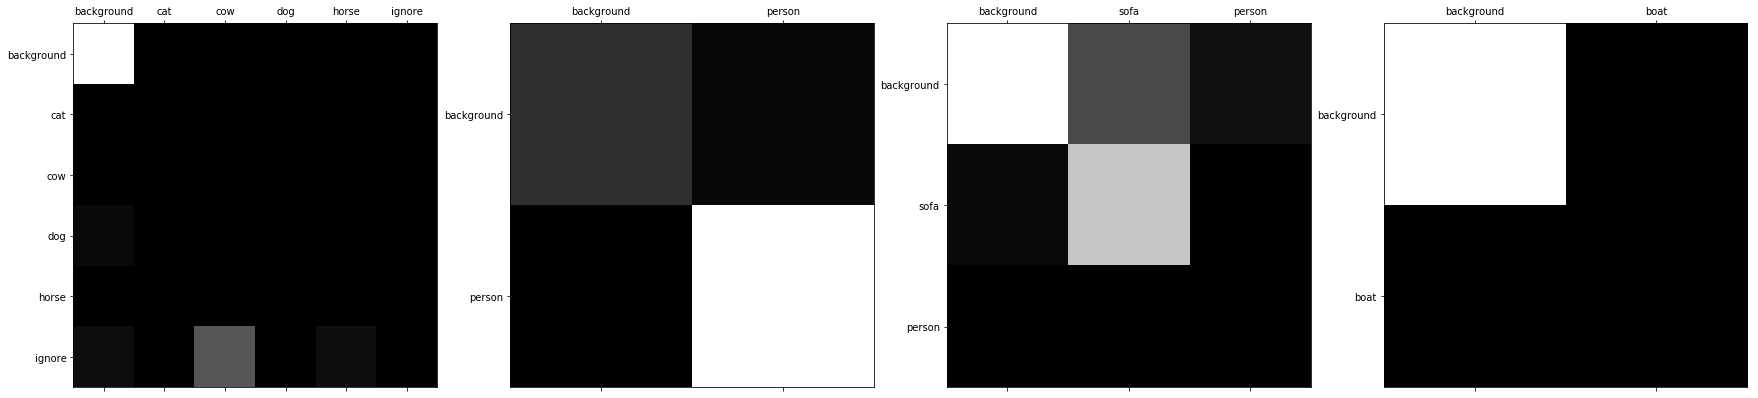


-------------------- END SESSION - 2018-09-01 10:20 -------------------------



In [27]:
# main process
delimiter = "/"
fp_resume = readResume()

# current painting
current_painting = fp_resume.split("/")
current_painting = current_painting[len(current_painting) - 1].rstrip() # rstrip() for removing white spaces and new line instances

# paintings_path
paintings_path = fp_resume.split("/")
paintings_path.remove(paintings_path[len(paintings_path) - 1])
paintings_path = delimiter.join(paintings_path)

# labels_path
labels_path = fp_resume.split("/")
labels_path.remove(labels_path[len(labels_path) - 1])
labels_path.remove(labels_path[len(labels_path) - 1])
labels_path.append("SegmentationClassPNG")
labels_path = delimiter.join(labels_path)

paintings = getPaintings(paintings_path)
# print(paintings)

loop(paintings_path, labels_path, paintings, current_painting)